In [18]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["font.size"] = 14
import warnings
warnings.simplefilter("ignore")
import datetime as dt

pulls_raw = pd.read_csv("../data/repos_with_class_info.csv")
errors = pd.read_csv("../data/num_errors.csv")

In [19]:
errors.sort_values("timestamp").iloc[0,0]

'2019-09-11 19:00:00'

In [20]:
pulls = pulls_raw.groupby(["class", "timestamp"]).first().reset_index()
pulls = pulls[pulls["timestamp"] >= errors.sort_values("timestamp").iloc[0,0]]
pulls["pull_count"] = pulls_raw.groupby(["class", "timestamp"]).count().reset_index()["org"]
pulls.head()

,class,timestamp,org,repo,size_KB,size,pull_count
357,COGSCI 1,2019-09-11 19:00:00,ds-modules,COGSCI-1,185.0,145.0,4
358,COGSCI 1,2019-09-11 20:00:00,ds-modules,COGSCI-1,26153.0,145.0,7
359,COGSCI 1,2019-09-11 22:00:00,ds-modules,COGSCI-1,185.0,145.0,5
360,COGSCI 1,2019-09-11 23:00:00,ds-modules,COGSCI-1,185.0,145.0,46
361,COGSCI 1,2019-09-12 00:00:00,ds-modules,COGSCI-1,185.0,145.0,2


In [21]:
data = pd.merge(pulls, errors, on="timestamp", how="left").fillna(0).rename({"value": "errors"}, axis=1)
data.head()

,class,timestamp,org,repo,size_KB,size,pull_count,errors
0,COGSCI 1,2019-09-11 19:00:00,ds-modules,COGSCI-1,185.0,145.0,4,501.25
1,COGSCI 1,2019-09-11 20:00:00,ds-modules,COGSCI-1,26153.0,145.0,7,0.00
2,COGSCI 1,2019-09-11 22:00:00,ds-modules,COGSCI-1,185.0,145.0,5,0.00
3,COGSCI 1,2019-09-11 23:00:00,ds-modules,COGSCI-1,185.0,145.0,46,0.00
4,COGSCI 1,2019-09-12 00:00:00,ds-modules,COGSCI-1,185.0,145.0,2,0.00


In [36]:
data.to_csv("../data/classes_and_errors.csv", index=False)

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

def rmse(y, y_hat):
    return np.mean((y - y_hat)**2)

In [23]:
train_raw, test_raw = train_test_split(data, random_state=42)
train_raw.shape, test_raw.shape

((6847, 8), (2283, 8))

In [24]:
def prepare_data(df):
    global column_index
    df = pd.get_dummies(df, columns=["class", "org"], drop_first=True)
    for c in data["class"].unique():
        if "class_" + c not in df.columns:
            df["class_" + c] = 0
    for o in data["org"].unique():
        if "org_" + o not in df.columns:
            df["org_" + o] = 0
    df = df.drop(["timestamp", "repo"], axis=1)
    
    # set column_index global so that we get the same order of columns
    try:
        if column_index is None:
            column_index = df.columns
    except NameError:
        column_index = df.columns
        
    return df[column_index]

train = prepare_data(train_raw)
X_train, y_train = train.drop("errors", axis=1).values, train["errors"]

test = prepare_data(test_raw)
X_test, y_test = test.drop("errors", axis=1).values, test["errors"]

In [25]:
def run_model(model, X, y, Xt, yt, classifier=False, error_fn=rmse):
    model.fit(X, y)
    train_pred = model.predict(X)
    test_pred = model.predict(Xt)
    
    if classifier:
        return accuracy_score(y, train_pred), accuracy_score(yt, test_pred), model
    else:
        return error_fn(y, train_pred), error_fn(yt, test_pred), model

In [26]:
models = pd.DataFrame({"model": [], "train_error": [], "test_error": []})

linear model

In [27]:
model_1 = run_model(LinearRegression(), X_train, y_train, X_test, y_test)
models = models.append(
    {"model": "linear regression", "train_error": model_1[0], "test_error": model_1[1]}, ignore_index=True
)
models

,model,test_error,train_error
0,linear regression,11097.862772,11607.966992


In [78]:
model_2_cv = GridSearchCV(
    HuberRegressor(), 
    {"epsilon": np.geomspace(1, 1e3, 10), "alpha": np.geomspace(1e-6, 1e-3, 10)}, 
    n_jobs=-1
)
model_2_cv.fit(X_train, y_train)
model_2_cv.best_estimator_

HuberRegressor(alpha=0.00021544346900318823, epsilon=21.544346900318832,
        fit_intercept=True, max_iter=100, tol=1e-05, warm_start=False)

In [29]:
model_2 = run_model(HuberRegressor(epsilon=21.544346900318832, alpha=0.00021544346900318823), X_train, y_train, X_test, y_test)
models = models.append(
    {"model": "Huber regressor", "train_error": model_2[0], "test_error": model_2[1]}, ignore_index=True
)
models

,model,test_error,train_error
0,linear regression,11097.862772,11607.966992
1,Huber regressor,11314.020780,11830.325589


In [80]:
model_3 = run_model(DecisionTreeRegressor(random_state=42), X_train, y_train, X_test, y_test)
models = models.append(
    {"model": "decision tree regressor", "train_error": model_3[0], "test_error": model_3[1]}, ignore_index=True
)
models

,model,test_error,train_error
0,linear regression,11097.862772,11607.966992
1,Huber regressor,11048.727189,11642.242004
2,Huber regressor,11314.020780,11830.325589
3,decision tree regressor,12839.791385,8611.719885


In [83]:
model_4_cv = GridSearchCV(
    LinearSVR(), 
    {"epsilon": np.geomspace(1e-9, 1e3, 10), "C": np.geomspace(1e-12, 1e-9, 10)}, 
    n_jobs=-1
)
model_4_cv.fit(X_train, y_train)
model_4_cv.best_estimator_

LinearSVR(C=1e-09, dual=True, epsilon=46.41588833612773, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [84]:
model_4 = run_model(LinearSVR(epsilon=46.41588833612773, C=1e-09), 
                    X_train, y_train, X_test, y_test)
models = models.append(
    {"model": "linear support vector regressor", "train_error": model_4[0], "test_error": model_4[1]}, ignore_index=True
)
models

,model,test_error,train_error
0,linear regression,11097.862772,11607.966992
1,Huber regressor,11048.727189,11642.242004
2,Huber regressor,11314.020780,11830.325589
3,decision tree regressor,12839.791385,8611.719885
4,linear support vector regressor,11510.356094,12021.652498


In [85]:
%%time
model_5_cv = GridSearchCV(
    MLPRegressor(random_state=42), 
    {
        "alpha": np.geomspace(1e-9, 1e3, 10), 
        "learning_rate_init": np.geomspace(1e-9, 1e3, 10),
    }, 
    n_jobs=-1
)
model_5_cv.fit(X_train, y_train)
model_5_cv.best_estimator_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CPU times: user 11.4 s, sys: 1.53 s, total: 12.9 s
Wall time: 3min 24s


In [86]:
model_5_cv.best_estimator_

MLPRegressor(activation='relu', alpha=2.1544346900318822e-08,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [87]:
model_5 = run_model(MLPRegressor(random_state=42, alpha=2.1544346900318822e-08, learning_rate_init=0.1), 
                    X_train, y_train, X_test, y_test)
models = models.append(
    {"model": "multi-level perceptron NN regressor", "train_error": model_5[0], "test_error": model_5[1]}, ignore_index=True
)
models

,model,test_error,train_error
0,linear regression,11097.862772,11607.966992
1,Huber regressor,11048.727189,11642.242004
2,Huber regressor,11314.020780,11830.325589
3,decision tree regressor,12839.791385,8611.719885
4,linear support vector regressor,11510.356094,12021.652498
5,multi-level perceptron NN regressor,11078.291349,11664.031694


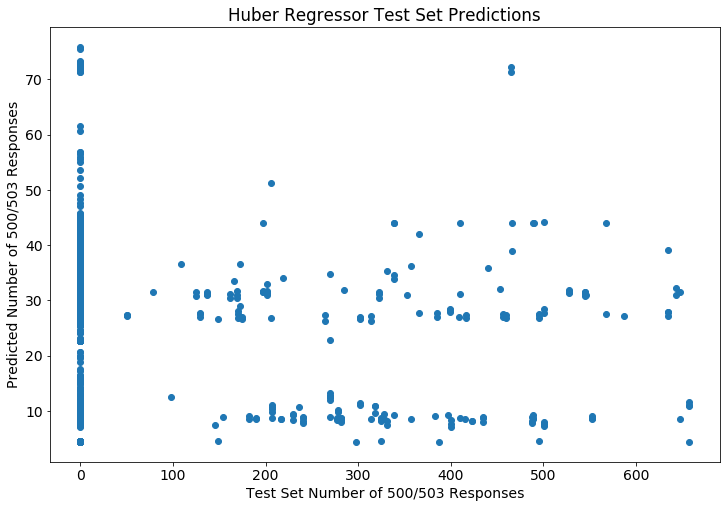

In [35]:
test_pred = model_2[2].predict(X_test)

plt.scatter(y_test, test_pred)
plt.xlabel("Test Set Number of 500/503 Responses")
plt.ylabel("Predicted Number of 500/503 Responses")
plt.title("Huber Regressor Test Set Predictions");

In [13]:
from scipy import io

processed_data = {
    "X_train": X_train,
    "y_train": y_train.values,
    "X_test": X_test,
    "y_test": y_test.values
}

io.savemat("../data/modeling_processed_data.mat", processed_data)

In [30]:
from joblib import dump
dump(model_2[2], "../data/nb05-trained-model.joblib")

['../data/nb05-trained-model.joblib']